In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
from sklearn.cluster import OPTICS
import hdbscan
from umap.umap_ import UMAP
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score

In [5]:
classes = pd.read_csv('/datasets/bitcoin/elliptic_txs_classes.csv')
classes = classes.loc[classes['class'] != 'unknown']
edges = pd.read_csv('/datasets/bitcoin/elliptic_txs_edgelist.csv')
edges = edges.merge(classes, left_on='txId1', right_on='txId', how='inner')
edges = edges.merge(classes, left_on='txId2', right_on='txId', how='inner')
edges.drop(['txId_x', 'class_x', 'txId_y', 'class_y'], axis=1, inplace=True)

features = pd.read_csv('/datasets/bitcoin/elliptic_txs_features.csv', header=None)
left = edges.merge(features, left_on="txId1", right_on=0, how="left").drop(["txId1", "txId2", 1, 0], axis=1)
right = edges.merge(features, left_on="txId2", right_on=0, how="left").drop(["txId1", "txId2", 1, 0], axis=1)
for_cluster = (left - right).astype(float)

In [6]:
for i in range(20):
    kmeans = KMeans(n_clusters=3+i, random_state=0, n_init=20).fit_predict(for_cluster)
    edges[f'kmeans_cluster_{i}'] = kmeans

In [7]:
for i in range(50,100,5):
    scan = hdbscan.HDBSCAN(min_cluster_size=i)
    scan.fit(for_cluster)
    edges[f'HDBSCAN_{i}'] = scan.labels_

In [ ]:
edges[f'OPTICS'] = OPTICS().fit_predict(for_cluster)

In [ ]:
edges.to_csv('clustering_results.csv', index=False)
collector = {'davies_bouldin_score': {},
             'calinski_harabasz_score': {},
             'silhouette_score': {},
            }
for i in edges.columns:
    try:
        collector['davies_bouldin_score'][i] = davies_bouldin_score(for_cluster, np.ravel(edges[i]))
        collector['calinski_harabasz_score'][i] = calinski_harabasz_score(for_cluster, np.ravel(edges[i]))
        collector['silhouette_score'][i] = silhouette_score(for_cluster, np.ravel(edges[i]))
    except ValueError:
        collector['davies_bouldin_score'][i] = np.nan
        collector['calinski_harabasz_score'][i] = np.nan
        collector['silhouette_score'][i] = np.nan
    print(f'iteration [{collector["davies_bouldin_score"][i]}, {collector["calinski_harabasz_score"][i]}, {collector["silhouette_score"][i]}], ')
pd.DataFrame(collector).to_csv('clustering_scores.csv')


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


(36624, 2)


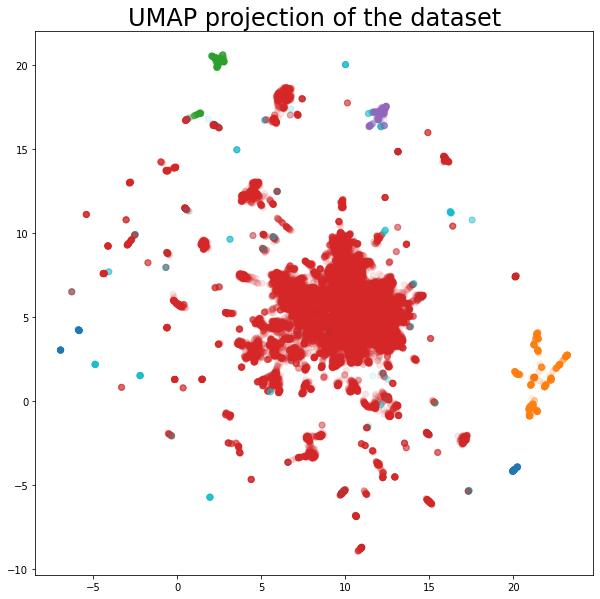

In [15]:
reducer = UMAP()

clustered_edge_diff = for_cluster #pd.concat([for_cluster, hdb_70] , axis = 1)
clustered_edge_diff.columns = clustered_edge_diff.columns.astype(str)
scaled_data = StandardScaler().fit_transform(clustered_edge_diff)
embedding = reducer.fit_transform(scaled_data)
print(embedding.shape)
plt.figure(figsize=(10,10))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in edges['HDBSCAN_70']], alpha = 0.1)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the dataset', fontsize=24);
